![header](assets/header.png)

# Node Classification with Custom Model - Introduction
In this Notebook we are going to examine how to develop and incorporate user-provided model for Amazon Neptune ML to perform node classification in a property graph.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: Make sure you're running the notebook with the <b>conda_neptune_ml_p36</b> jupyter kernel. This notebook take approximately 1 hour to complete</div>

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models within Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy to use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph. 

This notebook follows the structure of the default [Neptune ML Node Classification tutorial](https://github.com/aws/graph-notebook/blob/main/src/graph_notebook/notebooks/04-Machine-Learning/Neptune-ML-01-Introduction-to-Node-Classification-Gremlin.ipynb) to make it easy to follow along and highligh the key differences when using a custom model with Neptune ML.

Node classification is a common semi-supervised machine learning task that is handled automatically by the built-in models in Neptune ML. However, if you need to add customization to the model training step or want more granular control over the model used then you can implement your own custom model for the task.

Node classification is commonly used to solve many common buisness problems such as:

* [Identifying fradulent transactions](https://aws.amazon.com/blogs/machine-learning/detecting-fraud-in-heterogeneous-networks-using-amazon-sagemaker-and-deep-graph-library/)
* Predicting group membership in a social or identity network
* Predicting categories for product recommendation
* Predicting user churn

This notebook shows how to use the RGCN model implementation provided by the neptune ml toolkit model zoo as the basis of a custom model implementation for node classification. While the Neptune ML toolkit provides the implementation of the model architecture, the [`src/`](./src) module defines the custom hyperparameters and implements the model training process.

The overall workflow for using custom models with Neptune ML is similar to the Neptune ML automatic model workflow and involves a four step process to automate the process of creating production ready GNN models:

1. **Load Data** - Data is loaded into a Neptune cluster using any of the normal methods such as the Gremlin drivers or using the Neptune Bulk Loader.
2. **Export Data** - A service call is made specifying the machine learning model type and model configuration parameters.  The data and model configuration parameters are then exported from a Neptune cluster to an S3 bucket.
3. **Model Training** - A set of service calls are made to pre-process the exported data, train the machine learning model, and then generate an Amazon SageMaker endpoint that exposes the model.
4. **Run Queries** - The final step is to use this inference endpoint within our Gremlin queries to infer data using the machine learning model.

The **Model Training** part of the workflow when using Neptune ML's built-in models consist of:

* Data Processing API call
* Model Training API call
* Inference Endpoint API call

During the experimentation and development phase, when using custom models, there's an extra step between Data Processing API call and the Model Training API call for model implementation and local model testing.
So the overall **Model Training** part consists of:
* Data Processing API call
* *Model development and local testing*
* Model Training API call
* Inference Endpoint API call


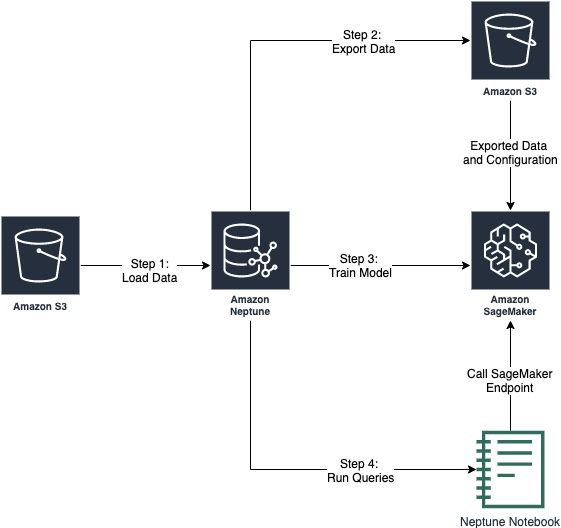

Like the automatic model workflow example notebook, this notebook uses the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) provided by [GroupLens Research](https://grouplens.org/datasets/movielens/). This dataset consists of movies, users, and ratings of those movies by users.


For this notebook we'll walk through how Neptune ML can predict the group membership of a product in a product graph.  To demonstrate this we'll predict the genre of movies in our graph.  We'll walk through each step of loading and exporting the data, processing the data, developing and locally testing the model, training the model, and finally we'll show how to use that model to infer the genre of movies using Gremlin traversals.
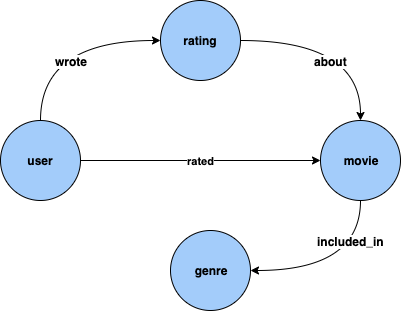

## Checking that we are ready to run Neptune ML 
Run the code below to check that this cluster is configured to run Neptune ML.

In [ ]:
import neptune_ml_utils as neptune_ml
neptune_ml.check_ml_enabled()

If the check above did not say that this cluster is ready to run Neptune ML jobs then please check that the cluster meets all the pre-requisites defined [here](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview).

# Load the data
The first step in building a Neptune ML model is to load data into the Neptune cluster. Loading data for Neptune ML follows the standard process of ingesting data into Amazon Neptune, for this example we'll be using the Bulk Loader. 

We have written a script that automates the process of downloading the data from the MovieLens websites and formatting it to load into Neptune. All you need to provide is an S3 bucket URI that is located in the same region as the cluster.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This is the only step that requires any specific input from the user, all remaining cells will automatically propogate the required values.</div>


In [ ]:
s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

Now that you have provided an S3 bucket, run the cell below which will download and format the MovieLens data into a format compatible with Neptune's bulk loader.

In [ ]:
response = neptune_ml.prepare_movielens_data(s3_bucket_uri)

This process only takes a few minutes and once it has completed load the data using the `%load` command in the cell below.

In [ ]:
%load -s {response} -f csv -p OVERSUBSCRIBE --run

## Check to make sure the data is loaded

Once the cell has completed, the data has been loaded into the cluster. We verify the data loaded correctly by running the traversals below to see the count of nodes by label:  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The numbers below assume no other data is in the cluster</div>

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold().order().by(keys)

If our nodes loaded correctly then the output is:

* 19 genres
* 1682 movies
* 100000 rating
* 943 users

To check that our edges loaded correctly we check the edge counts:

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold().order().by(keys)

If our edges loaded correctly then the output is:

* 100000 about
* 2893 included_in
* 100000 rated
* 100000 wrote


## Preparing for export

With our data validated, let's simulate new movies being added into our product knowledge graph by removing the `genre` property from a few `movie` nodes.  Specifically, let's focus on a couple of Tom Hanks movies from the mid-1990's, `Apollo 13`, `Forrest Gump`, and `Sleepless in Seattle`. 

Let's begin by taking a look at the current value of the `genre` property for each movie.

In [ ]:
%%gremlin

g.V().has('movie', 'title', within('Apollo 13 (1995)', 'Forrest Gump (1994)', 'Sleepless in Seattle (1993)')).
    valueMap('title', 'genre')

Now let's remove these property values from the data.

In [ ]:
%%gremlin
g.V().has('movie', 'title', within('Apollo 13 (1995)', 'Forrest Gump (1994)', 'Sleepless in Seattle (1993)')).
    properties('genre').drop()

Checking our movies again we see that they no longer have any `genre` values.

In [ ]:
%%gremlin

g.V().has('movie', 'title', within('Apollo 13 (1995)', 'Forrest Gump (1994)', 'Sleepless in Seattle (1993)')).
    valueMap('title', 'genre')

With these `genre` properties removed we're ready to build our Neptune ML Node Classification model to predict the categories for these movies in our product knowledge graph.  


# Export the data and model configuration

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: Before exporting data ensure that Neptune Export has been configured as described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html#machine-learning-data-export-service-run-export">Neptune Export Service</a></div>

With our product graph loaded we are ready to export the data and configuration which will be used to train the ML model.

The export process is triggered by calling to the [Neptune Export service endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html).  This call contains a configuration object which specifies the type of machine learning model to build, in this example node classification, as well as any feature configurations required.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The configuration used in this notebook specifies only a minimal set of configuration options meaning that our model's predictions are not as accurate as they could be.  The parameters included in this configuration are one of a couple of sets of options available to the end user to tune the model and optimize the accuracy of the resulting predictions.</div>

The configuration options provided to the export service are broken into two main sections, selecting the target and configuring features. 

## Selecting the target

In the first section, selecting the target, we specify what type of machine learning task will be run, and in the case of node classification, what the target node label and property we want to predict.  To run a node classification task we are only required to specify the node label and target property to infer. 

In this example below we specify the `genre` property on the `movie` node as our target for prediction by including these values in the `targets` sub-parameter of the `additionalParams` object as shown below. 

```
"additionalParams": {
        "neptune_ml": {
          "targets": [
            {
              "node": "movie",
              "property": "genre"
            }
          ],
          ....
```

## Configuring features
The second section of the configuration, configuring features, is where we specify details about the types of data stored in our graph and how the machine learning model should interpret that data.  In machine learning, each property is known as a feature and these features are used by the model to make predictions.

In our export example below we have specified that the `title` property of our `movie` should be exported and trained as a `text_word2vec` feature and that our `age` field should range from 0-100 and that data should be bucketed into 10 distinct groups. See the [documentation for feature encoding](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-feature-encoding.html) to learn more about supported feature transformations in Neptune ML.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Important</b>: The example below is an example of a minimal amount of the features of the model configuration parameters and will not create the most accurate model possible.  Additional options are available for tuning this configuration to produce an optimal model are described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-parameters.html">Neptune Export Process Parameters</a></div>

Running the cell below we set the export configuration and run the export process.  Neptune export is capable of automatically creating a clone of the cluster by setting `cloneCluster=True` which takes about 20 minutes to complete and will incur additional costs while the cloned cluster is running.  Exporting from the existing cluster takes about 5 minutes but requires that the `neptune_query_timeout` parameter in the [parameter group](https://docs.aws.amazon.com/neptune/latest/userguide/parameters.html) is set to a large enough value (>72000) to prevent timeout errors.

In [ ]:
export_params={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
            "useIamAuth": neptune_ml.get_iam(),
            "cloneCluster": False
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export',
"additionalParams": {
        "neptune_ml": {
          "version": "v2.0",
          "targets": [
            {
              "node": "movie",
              "property": "genre",
              "type": "classification"
            }
          ],
         "features": [
            {
                "node": "movie",
                "property": "title",
                "type": "text_word2vec"
            },
            {
                "node": "user",
                "property": "age",
                "type": "bucket_numerical",
                "range" : [1, 100],
                "num_buckets": 10
            }
         ]
        }
      },
"jobSize": "medium"}

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

# ML data processing, model development, model training, and endpoint creation

Once the export job is completed we are now ready to train our machine learning model and create the inference endpoint. Training our Neptune ML model requires a few steps.
  
<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The cells below only configure a minimal set of parameters required to run a model training.</div>

## Data processing 
The first step (data processing) processes the exported graph dataset using standard feature preprocessing techniques to prepare it for use by DGL. This step performs functions such as feature normalization for numeric data and encoding text features using word2vec. At the conclusion of this step the dataset is formatted for model training. 

This step is implemented using a SageMaker Processing Job and data artifacts are stored in a pre-specified S3 location once the job is complete.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Data Processing](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing.html)
* [dataprocessing command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-dataprocessing.html)

Run the cells below to create the data processing configuration and to begin the processing job.

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto generated
training_job_name=neptune_ml.get_training_job_name('node-classification')

processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """

print(training_job_name)

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}


## Model development and local testing
The next step consists of developing the model, writing the model training code, and testing the custom implementation before full-fledged model training.

The custom model implementation is provided in the [`src/`](src/) directory which has the following contents.

* **[`model-hpo-configuration.json`](src/model-hpo-configuration.json)** contains the configuration for the model hyperparameters, their defaults and ranges according to the [Neptune ML hyperparameter configuration specificaton](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-customizing-hyperparams.html)
* **[`train.py`](src/train.py)** is the entrypoint script for model training. It contains the custom model code implementation, and when executed, runs model training with the hyperparameter values passed in as program arguments.
* **[`transform.py`](src/transform.py)** is the entrypoint script for [model transform](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-model-transform.html). When executed, it computes the model artifacts that will be needed when the model is deployed to an inference endpoint


Let's take a look at the training script in more detail


In [ ]:
!pygmentize src/train.py


As you can see the `train.py` defines the `RGCNNodeClassification` model using the implementation provided by the Neptune ML Toolkit modelzoo. The modelzoo contains reusable modular GNN components implemented in DGL(https://github.com/dmlc/dgl) with the Pytorch backend, which you can use in your custom implementations.

The script also implements functions to train this model architecture using pytorch.

We can run this script locally, to test it out and really see the training in action but first we need to bring the processed data locally and create a folder to store the training output.


In [ ]:
s3_processed_data = f"""{str(s3_bucket_uri)}/preloading"""

!aws s3 cp --recursive $s3_processed_data data/

!mkdir output/

Now let's run the training script

In [ ]:
!python src/train.py --local

This should have run succesfully for a few epochs and generated some files in `output/`.
The model parameters are in `output/model.pt` and evaluation metrics for the training run are in `output/eval_metrics_info.json`.
The contents of output are what will be generated when we train with the Neptune ML modeltraining API later.


Let's also take a look at the transform script in detail

In [ ]:
!pygmentize src/transform.py

The transform script is what is used to compute the model artifacts such as node embeddings and precomputed predictions needed for inference.

The transform script can also be run on the local instance.

In [ ]:
!python src/transform.py --local

The transform script should have added even more files like `entity.npy` to the `output/` folder.
These files are needed to create the model that will be deployed but are not generated by `train.py`.
This is because when we train with the Neptune ML modeltraining API, `train.py` is executed by multiple SageMaker training jobs trying different hyperparameter configurations.
However, only the artifacts from the best training job are needed for the deployment.
Therefore, when using the Neptune ML train API, `transform.py` is called once on the output from the best training instance.


Now, that we have verified locally that both of the entry point scripts work, we can move to the next of training using the Neptune ML modeltraining API.

To do this we must first upload the `src/` to S3 so that the neptune ml modeltraining API can pick our custom model implementation.


In [ ]:
s3_custom_source_location = f"""{str(s3_bucket_uri)}/training/source/{training_job_name}"""

!aws s3 cp --recursive src/ $s3_custom_source_location

## Model training
The next step (model training) trains the ML model that will be used for predictions. The model training is done in stages. The first stage uses a SageMaker Processing job to parse the `model-hpo-configuration.json` and generate a model training strategy. A model training strategy is a configuration set that specifies what type of model and model hyperparameter ranges will be used for the model training. Once the first stage is complete, the SageMaker Processing job launches a SageMaker Hyperparameter tuning job. The SageMaker Hyperparameter tuning job runs a pre-specified number of model training job trials (`train.py`) on the processed data. Once all the training jobs are complete, the Hyperparameter tuning job also notes the training job that produced the best performing model.
The SageMaker Processing job then computes and stores (`transform.py`) the model artifacts generated by the best SageMaker training job in the output S3 location..

Additional options and configuration parameters for the model training job can be found using the links below:

* [Model Training](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-model-training.html)
* [modeltraining command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-modeltraining.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The model training process takes ~20 minutes</div>

For custom model training, we need to supply the `customModelParameters` to the api call to ensure that the training is done with the custom model implementation.


In [ ]:
# training_params=f"""
# --job-id {training_job_name}
# --data-processing-id {training_job_name}
# --instance-type ml.p3.2xlarge
# --s3-output-uri {str(s3_bucket_uri)}/training """

In [ ]:
%%bash
# %neptune_ml training start --wait --store-to training_results {training_params}

curl \
  -X POST https://(your Neptune endpoint)/ml/modeltraining
  -H 'Content-Type: application/json' \
  -d '{
        "id" : "<INSERT training job name from above>",
        "dataProcessingJobId" : "<INSERT training job name from above>",
        "trainModelS3Location" : "<INSERT S3 BUCKET OR PATH>",
        "trainingInstanceType" : "ml.g4.xlarge"
        "customModelParameters" : {
            "sourceS3DirectoryPath": "<INSERT Source S3 path from above>",
            "trainingEntryPointScript": "train.py",
            "transformEntryPointScript": "transform.py"
            }
      }'

Once the training job is completed, you will have a model that was trained using the custom implementation that was provided.

After this stage, all the following steps for endpoint creation and inference are identical to using the built-in Neptune ML models.

## Endpoint creation

The final step is to create the inference endpoint which is an Amazon SageMaker endpoint instance that is launched with the model artifacts produced by the best training job. This endpoint will be used by our graph queries to  return the model predictions for the inputs in the request. The endpoint once created stays active until it is manually deleted. Each model is tied to a single endpoint.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Inference Endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-inference-endpoint.html)
* [Endpoint command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-endpoints.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The endpoint creation process takes ~5-10 minutes</div>

In [ ]:
endpoint_params=f"""
--job-id {training_job_name} 
--model-job-id {training_job_name} """

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

Once this has completed we get the endpoint name for our newly created inference endpoint.  The cell below will set the endpoint name which will be used in the Gremlin queries below. 

In [ ]:
endpoint=endpoint_results['endpoint']['name']

# Predicting values using Gremlin queries

Now that we have our inference endpoint setup let's query our product knowledge graph to show how to predict categorical property values by predicting the the genre for our new movies, starting with `Apollo 13`.  

## Predicting movie genres
Before we predict the movie's genre let's verify that our graph does not contain any `genre` values for the `genre` of the `movie` *Apollo 13*.

In [ ]:
%%gremlin
g.V().has('title', 'Apollo 13 (1995)').properties("genre").value()

As expected this returned no values, so let's modify this query to predict the genre for `Apollo 13`.  To accomplish this we need to add two steps to the query above that let's it know to use Neptune ML to find the value.

First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The endpoint values are automatically passed into the queries below</div>

Second, when we ask for the property within our query we use the `properties()` step with an additional `with()` step (`with("Neptune#ml.classification")`) which specifies that we want to retrieve the predicted value for this property.

Putting these items together we get the query below, which will predict `genre` for the `Apollo 13` movie in our product knowledge graph.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${endpoint}').
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

Looking at the results, this prediction seems right, `Apollo 13` seems to fit well into the `Drama` genre.  

In many situations, you may want to predict multiple categories for a node.  For example, in our product knowledge graph a movie is likely to belong to multiple genres so we'll want to predict these multiple genres.  By default Neptune ML returns the top result, but we specify the number of results to return using the `.with("Neptune#ml.limit",3)` configuration option as shown below.  

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
  with("Neptune#ml.limit",3).
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

Looking at the results, `Drama` and `Thriller` seem to be accurate but the other option does not quite seem correct.  In the query above we are asking for the top 3 predicted results for `genre`.  Each value returned by Neptune ML has a confidence score associated with it and the query above returns the top three results, no matter the confidence in the prediction. While this score is not available at query time it can be used to filter out predictions with a low confidence.  

Let's say that we wanted to return the top 3 genres for `Apollo 13` but only if the prediction has a a certain level of confidence.  To achieve this we add this filter to the query above using the `.with("Neptune#ml.threshold",0.XD)` where the `0.XD` value represents the confidence from `0..1` that you would like to have.  Let's take a moment to look at how changing this value can change the results returned.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
  with("Neptune#ml.limit",3).
  with("Neptune#ml.threshold",0.9D).
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
  with("Neptune#ml.limit",3).
  with("Neptune#ml.threshold",0.7D).
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
  with("Neptune#ml.limit",3).
  with("Neptune#ml.threshold",0.5D).
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
  with("Neptune#ml.limit",3).
  with("Neptune#ml.threshold",0.3D).
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
  with("Neptune#ml.limit",3).
  with("Neptune#ml.threshold",0.1D).
  V().has('title', 'Apollo 13 (1995)').properties("genre").with("Neptune#ml.classification").value()

As we see, depending on the threshold value specified the results where the confidence does not meet that threshold are removed.

So far we have only been working on a single movie, but let's say you wanted to predict the genre for all movies without a `genre`, we can accomplish this using the query below.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
    V().hasLabel('movie').hasNot('genre').
    project('title', 'predicted_genre').
        by('title').
        by( properties("genre").with("Neptune#ml.classification").value()).
    order(local).by(keys, desc)

We can also apply the same filters shown above to this query to find the top 3 genres for all our "new" movies, as long as the prediction has >70% confidence.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint","${endpoint}").
    with("Neptune#ml.limit", 3).
    with("Neptune#ml.threshold", 0.7D).
    V().hasLabel('movie').hasNot('genre').
    project('title', 'predicted_genre').
        by('title').
        by(properties("genre").with("Neptune#ml.classification").value().fold()).
    order(local).by(keys, desc)

Now that we've seen how to use Neptune ML to predict these categories, the next question is, how good are the predictions.  

## Comparing the accuracy of predicted and actual genres
If you look at the data model for our product knowledge graph you will created it with a `genre` vertex so that we can validate our predictions.  In a real world scenario you would not have this sort of categorical information, if you had it there would be no reason to predict it via Neptune ML.  Just for this sample we left it in to allow us to write a query that returns both the predicted and actual genre values for our new movies.  If we run the query below we will see the predicted versus actual genres for each of our movies.

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", "${endpoint}").
    with("Neptune#ml.limit", 3).
  V().hasLabel('movie').hasNot('genre').
  project('title', 'real', 'predicted').
    by('title').
    by(out('included_in').id().fold()).
    by(
      properties("genre").with("Neptune#ml.classification").
      value().fold()).
    order(local).by(keys, desc)

Comparing the `real` versus the `predicted` results we see that our model did a good job of predicting the genres of these movies, with all the predicted values existing in the real values. 

# Cleaning up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.


In [ ]:
neptune_ml.delete_endpoint(endpoint)

In addition to the inference endpoint the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see Deleting a Stack on the AWS CloudFormation Console. Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.